In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests as padjust_test

In [2]:
import sys
sys.path.append("MIST/")
import ReST
from scipy.stats import ranksums

/home/humble_local_25t/alexw/miniconda3/envs/ReST/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
data = ReST.ReST()
data.load("data/MIST/")
data.adata.obs.set_index("new_idx",
                         inplace=True, drop=True)

Please use load() function to load data. Otherwise, no useful info. can be used.


In [4]:
#res_rctd = pd.read_csv("/home/humble_local_25t/alexw/projects/ShawnLab/EMS_deconv_0307/output_files/24679/EMS_results/RCTD_props.csv",
#                       sep=',', index_col=0)
res_primary = pd.read_csv("data/ReSort_primary/primary_props.csv", index_col=0)
res_primary = res_primary.loc[:, ['E', 'M', 'S']]
res_primary = res_primary.divide(res_primary.sum(axis=1), axis=0)

In [5]:
immune_celltypes = ['B cells memory','B cells naive','Dendritic cells activated',
 'Dendritic cells resting','Eosinophils','Macrophages M0','Macrophages M1','Macrophages M2',
 'Mast cells activated', 'Mast cells resting','Monocytes','Neutrophils','NK cells activated',
 'NK cells resting','Plasma cells','T cells CD4 memory activated','T cells CD4 memory resting',
 'T cells regulatory (Tregs)', 'T cells CD4 naive','T cells CD8','T cells follicular helper',
                    'T cells gamma delta']

immune_labels = ['B memory', 'B naive','Dendritic Act.',
          'Dendritic rest.', 'Eosinophils', 'Macro. M0','Macro. M1','Macro. M2',
          'Mast Act.', 'Mast rest', 'Monocytes','Neutrophils','NK Act.',
          'NK rest', 'Plasma', 'T CD4 mem. Act.','T CD4 mem. rest', 
           'Tregs' , 'T CD4 naive', 'T CD8', 'T follicular helper', 
                   'T gamma delta',  ]
immune_hmap = dict(zip(immune_celltypes, immune_labels))
print(len(immune_celltypes))


22


In [6]:
data.adata.obs['E'] = data.adata.obs.index.map(dict(zip(res_primary.index.tolist(), res_primary.E.tolist())))
data.adata.obs['M'] = data.adata.obs.index.map(dict(zip(res_primary.index.tolist(), res_primary.M.tolist())))
data.adata.obs['S'] = data.adata.obs.index.map(dict(zip(res_primary.index.tolist(), res_primary.S.tolist())))

{'RMSE', 'Correlation', 'P-value'}


(-5.65, 118.65, 80.2, 9.8)

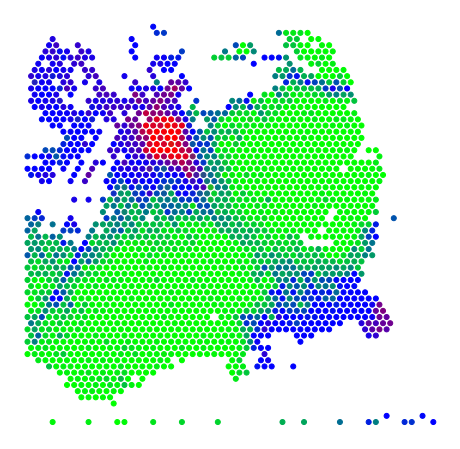

In [7]:
####  Read results after running CIBERSORTx with LM22 reference #####

#ori_path = "../output_files/24679/LM22_results/CIBERSORTx_24679_LM22.csv"
lm22_path = "data/CIBERSORTx_LM22/CIBERSORTx_LM22_result.csv"
lm22_props = pd.read_csv(lm22_path, index_col=0)
print(set(lm22_props.columns) - set(immune_celltypes))

lm22_props = lm22_props[immune_celltypes]
lm22_props = lm22_props.divide(res_primary.sum(axis=1), axis=0)
lm22_props = lm22_props.loc[res_primary.index,:]

#### Apply ReSort 2-nd step to normalize LM22 by Stroma's proportions
lm22_props_normed = (np.diag(res_primary.S) @ lm22_props)
lm22_props_normed.index = lm22_props.index
lm22_props_normed.fillna(0, inplace=True)
data.adata.obs = pd.concat([data.adata.obs, lm22_props_normed], axis=1)

#### Figure 4b
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1)
palette = {'0': 'green', '1': 'blue', 
           '5': "lightgray", 
           '6': 'lightgray', '8': 'red',
           'isolated': 'lightgray'}
data.assign_region_colors(palette)
plt.scatter(data.adata.obs.array_col,
            data.adata.obs.array_row,
            c=data.adata.obs[['E', 'M', 'S']].values, s=25)
plt.gca().invert_yaxis()
plt.axis("off")
#plt.savefig("figures/EMS_RGB_24679.png", dpi=100, bbox_inches='tight')

(1.4493804097175598, 13.054126489162446, -8.81989905834198, 17.86170098781586)

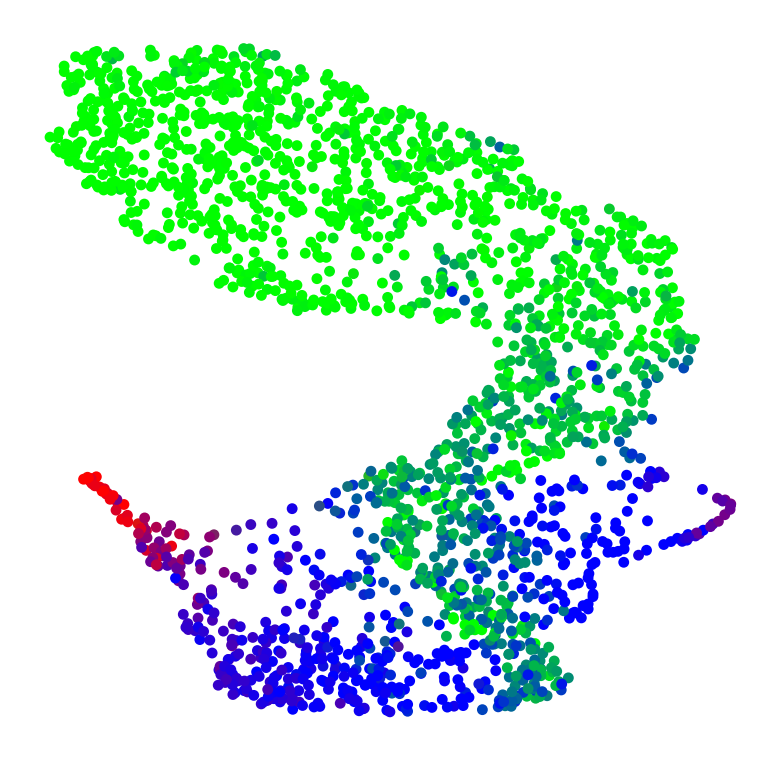

In [49]:
# #### Figure 5C - UMAP #####
sc.pp.neighbors(data.adata)
sc.tl.umap(data.adata)
sns.set_style("white")
plt.scatter(data.adata.obsm['X_umap'][:, 1],
            data.adata.obsm['X_umap'][:, 0],
            c=data.adata.obs[['E', 'M', 'S']].values, s=15, alpha=1)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.xticks([])
plt.yticks([])
plt.axis("off")
#plt.savefig("figures/Mixture_24679_EMS_umap_main.png", dpi=100, bbox_inches="tight")

In [9]:
### Stratification 
props = data.adata.obs.copy()
props['MixtureType'] = 'Stroma'
props.loc[(props.E > 0.5) & (props.S > 0.1), 'MixtureType'] = 'ES Mixture'
props.loc[(props.M > 0.5) & (props.S > 0.1), 'MixtureType'] = 'MS Mixture'
props.loc[(props.E > 0.9) , 'MixtureType'] = 'Pure Epi.'
props.loc[(props.M > 0.9) , 'MixtureType'] = 'Pure Mes.'
data.adata.obs = props.copy()

(-5.65, 118.65, 80.2, 9.8)

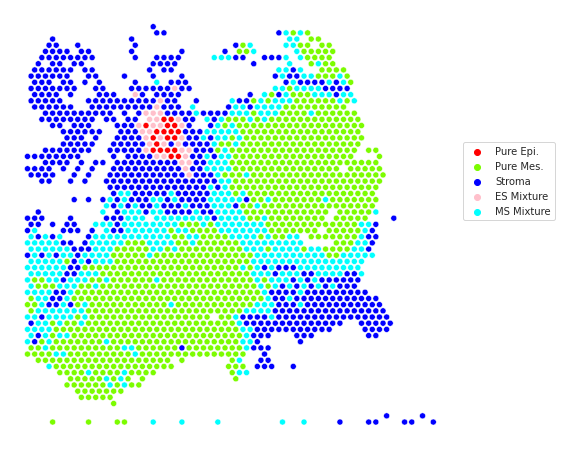

In [10]:
### Figure 4D
plt.figure(figsize=(8,8))
sns.set_style("white")
sns.scatterplot(data=props, x='array_col', y='array_row',
                hue='MixtureType', palette = {'Pure Epi.': "red", 'ES Mixture':'pink',
                                               'Pure Mes.': 'lawngreen', 'MS Mixture': 'cyan',
                                             'Stroma': 'blue'},
               hue_order = ['Pure Epi.', 'Pure Mes.', 'Stroma', 'ES Mixture', 'MS Mixture'])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 0.7))
plt.axis("off")
#plt.savefig("figures/defined_microenv_EMT_24679.png", dpi=100, bbox_inches='tight')

In [9]:
# ### Extract markers for TCGA validation
# from statsmodels.stats.multitest import multipletests
# from tqdm.notebook import tqdm

# genes = s24679.adata.var_names.tolist()
# espots = props.index[props.MixtureType.isin(['ES Mixture', 'Pure Epi.'])]
# mspots = props.index[props.MixtureType.isin(['MS Mixture', 'Pure Mes.'])]

# tcga_markers = []

# for gene in tqdm(genes):
#     es_gene_val = np.ravel(s24679.adata[espots, gene].X.toarray())
#     ms_gene_val = np.ravel(s24679.adata[mspots,  gene].X.toarray())
#     fc_em = np.power(2, np.mean(es_gene_val) - np.mean(ms_gene_val))
#     fc_me = np.power(2, np.mean(ms_gene_val) - np.mean(es_gene_val))    
#     pval = (ttest_ind(es_gene_val, ms_gene_val)[1])
    
#     marker = ''
#     if fc_em > 1.2 and pval < 0.01:
#         marker = 'E'
#     elif fc_me > 1.2 and pval < 0.01:
#         marker = 'M'
    
#     if marker != '':
#         df = pd.DataFrame(data=[[gene, max(fc_em, fc_me), pval, marker]],
#                          columns=['gene', 'fc', 'pval', 'marker'])
#         tcga_markers.append(df)

# tcga_markers = pd.concat(tcga_markers)
# tcga_markers['fdr'] = multipletests(tcga_markers.pval.tolist(), method='fdr_bh')[1]
# tcga_markers = tcga_markers.loc[tcga_markers.fdr <=0.05]
# top100_em_markers = pd.concat([df.iloc[:100] for _, df in tcga_markers.sort_values(['fdr']).groupby("marker")])
# top100_em_markers.gene = [g.upper() for g in top100_em_markers.gene]
# top100_em_markers.to_csv("TCGA_TNBC_validation/top100_em_markers.csv")

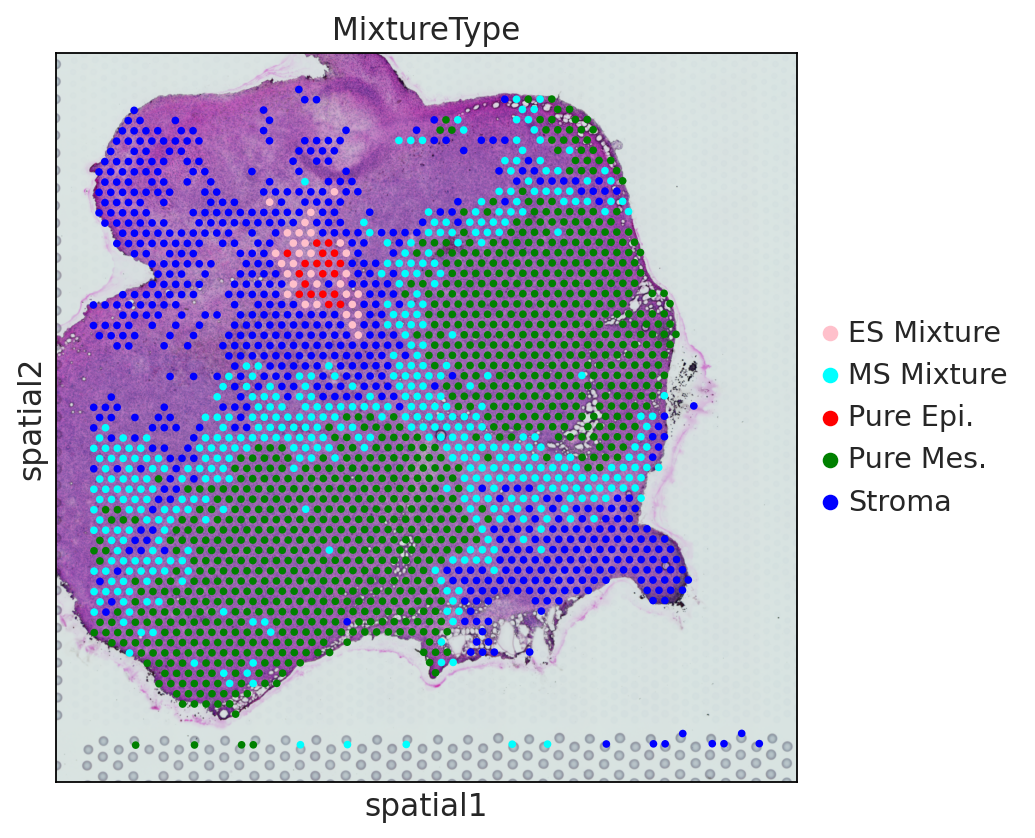

In [11]:
import warnings
warnings.filterwarnings("ignore")
sc.set_figure_params(figsize=(6,6))
sc.pl.spatial(data.adata[data.adata.obs.MixtureType != 'Others',:],
              color=['MixtureType'], palette = {'Pure Epi.': "red", 'ES Mixture':'pink',
                                               'Pure Mes.': 'green', 'MS Mixture': 'cyan',
                                               'Stroma': 'blue'})

In [69]:
# plt.figure(figsize=(4, 6))
# ms_props = props.loc[props.Mixture == 'MS', ].mean().sort_values(ascending=False)
# ms_props = pd.DataFrame(ms_props)
# ms_props.reset_index(drop=False, inplace=True)
# ms_props.columns=['cell_type', 'proportion']
# sns.barplot(data=ms_props.loc[~ms_props.cell_type.isin(['E', 'S', 'M'])],
#             x='proportion', y='cell_type', orient='h')

In [70]:
# plt.figure(figsize=(6, 8))
# es_props['Mixture'] = 'ES'
# ms_props['Mixture'] = 'MS'
# sns.barplot(data=pd.concat([ms_props.loc[~es_props.cell_type.isin(['E', 'S', 'M'])],
#                             es_props.loc[~es_props.cell_type.isin(['E', 'S', 'M'])]]),
#             x='proportion', y='cell_type', orient='h', hue='Mixture')

In [13]:
props1 = props.copy()
props1.loc[:, immune_celltypes] = (props1.loc[:, immune_celltypes] * 100).round(1)
props1.to_csv("data/ReSort_secondary/ReSort_props.csv")

## Statistical differences in LM22 between ES and MS

In [14]:
es_mix_all = data.adata.obs.loc[data.adata.obs.MixtureType == 'ES Mixture']
ms_mix_all = data.adata.obs.loc[data.adata.obs.MixtureType == 'MS Mixture']
print(es_mix_all.shape, ms_mix_all.shape)

(32, 43) (458, 43)


In [15]:
ct_res = []
for ct in immune_celltypes:
    es_c = es_mix_all[ct].to_numpy()
    ms_c = ms_mix_all[ct].to_numpy()
    mdiff = np.mean(es_c) - np.mean(ms_c)
    
    lfc = np.log2(np.mean(es_c) / np.mean(ms_c))
    
    fc_em = np.mean(es_c) / np.mean(ms_c)
    fc_me = np.mean(ms_c) / np.mean(es_c)
    
    pval = ttest_ind(es_c, ms_c)[1]
        
    df = pd.DataFrame(data=[[ct, mdiff, lfc, fc_em, fc_me, pval, '24679']], 
                      columns=['ICT', 'Mean_EM_diff','lfc','fc_em','fc_me', 'pvalue', 'sampleID'])
    ct_res.append(df)
ct_res = pd.concat(ct_res)

In [16]:
ct_res['FDR'] = padjust_test(ct_res.pvalue, method='fdr_bh')[1]
ct_res['FDR <= 0.05'] = np.where(ct_res['FDR'] <= 0.05, 'Yes', 'No')

In [17]:
ct_res.loc[ct_res['FDR <= 0.05'] == 'Yes']

ICT  Mean_EM_diff       lfc     fc_em     fc_me        pvalue  \
0  Macrophages M0      0.062467  2.900733  7.468056  0.133904  3.639230e-35   
0  Macrophages M1     -0.005248 -0.795871  0.575995  1.736125  7.615317e-03   
0  Macrophages M2      0.014456  1.328251  2.510980  0.398251  3.383311e-05   
0     Neutrophils      0.006101  0.836994  1.786324  0.559809  8.380576e-03   

  sampleID           FDR FDR <= 0.05  
0    24679  8.006305e-34         Yes  
0    24679  4.609317e-02         Yes  
0    24679  3.721642e-04         Yes  
0    24679  4.609317e-02         Yes

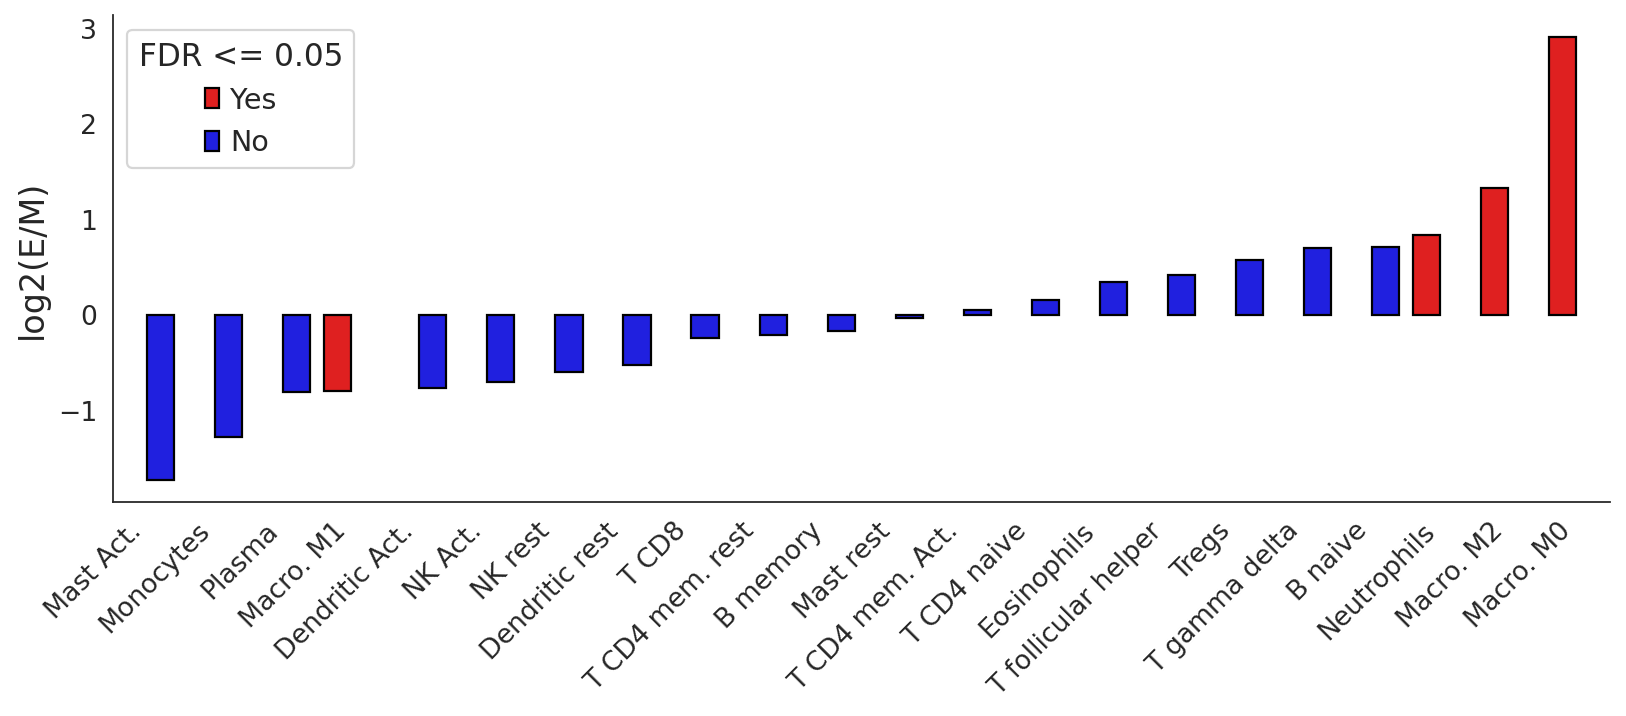

In [18]:
#### Figure 4e ####

sns.set_style("white")
ct_res.Mean_EM_diff = ct_res.Mean_EM_diff * 100
orders = ct_res.groupby('ICT').mean().sort_values("lfc").index.tolist()
f, ax = plt.subplots(1,1, figsize=(12,4))
fg = sns.barplot(data=ct_res, x='ICT', y='lfc',
                 hue='FDR <= 0.05', palette={'Yes': 'red', 'No': 'blue'}, order= orders,
                hue_order = ['Yes', 'No'], lw=1, ec='k')

labels = ax.get_xticklabels()  # get the position and text for each subplot

ax.set_ylabel("log2(E/M)", fontsize=15)
ax.set_xlabel("")
labels = ['Mast Act.', 'Monocytes', 'Plasma', 'Macro. M1', 'Dendritic Act.', 'NK Act.',
                   'NK rest', 'Dendritic rest', 'T CD8', 'T CD4 mem. rest', 'B memory', 'Mast rest',
                   'T CD4 mem. Act.', 'T CD4 naive', 'Eosinophils', 'T follicular helper', 
                  'Tregs' , 'T gamma delta', 'B naive','Neutrophils', 'Macro. M2', 'Macro. M0']
ax.set_xticklabels(labels, rotation=45, fontsize=14, ha='right')  # update the yticklabels
ax.tick_params(axis='both', labelsize=12)
ax.legend(title="FDR <= 0.05",loc=2)
sns.despine()
#plt.savefig("figures/EM_immune_difference_24679.pdf", dpi=200, bbox_inches='tight')

In [21]:
gene = 'Trem2'
for gene in ['Vim', 'Acp5', 'Trem2', 'Cd40']:
    es_gene_val = np.ravel(data.adata[es_mix_all.index, gene].X.toarray())
    ms_gene_val = np.ravel(data.adata[ms_mix_all.index, gene].X.toarray())
    fc_em = (np.mean(es_gene_val) / np.mean(ms_gene_val))
    fc_me = (np.mean(ms_gene_val)/np.mean(es_gene_val))
    pval = (ttest_ind(es_gene_val, ms_gene_val)[1])
    print(f"Gene = {gene}, FC(E/M) = {fc_em}, FC(M/E) = {fc_me}, p-value = {pval}")

Gene = Vim, FC(E/M) = 0.9345715641975403, FC(M/E) = 1.0700089931488037, p-value = 4.08028939523105e-20
Gene = Acp5, FC(E/M) = 2.2257742881774902, FC(M/E) = 0.44928184151649475, p-value = 7.02647670823636e-08
Gene = Trem2, FC(E/M) = 2.6371679306030273, FC(M/E) = 0.3791946470737457, p-value = 6.581890749587984e-06
Gene = Cd40, FC(E/M) = 0.09810413420200348, FC(M/E) = 10.19325065612793, p-value = 0.00046892189229520465


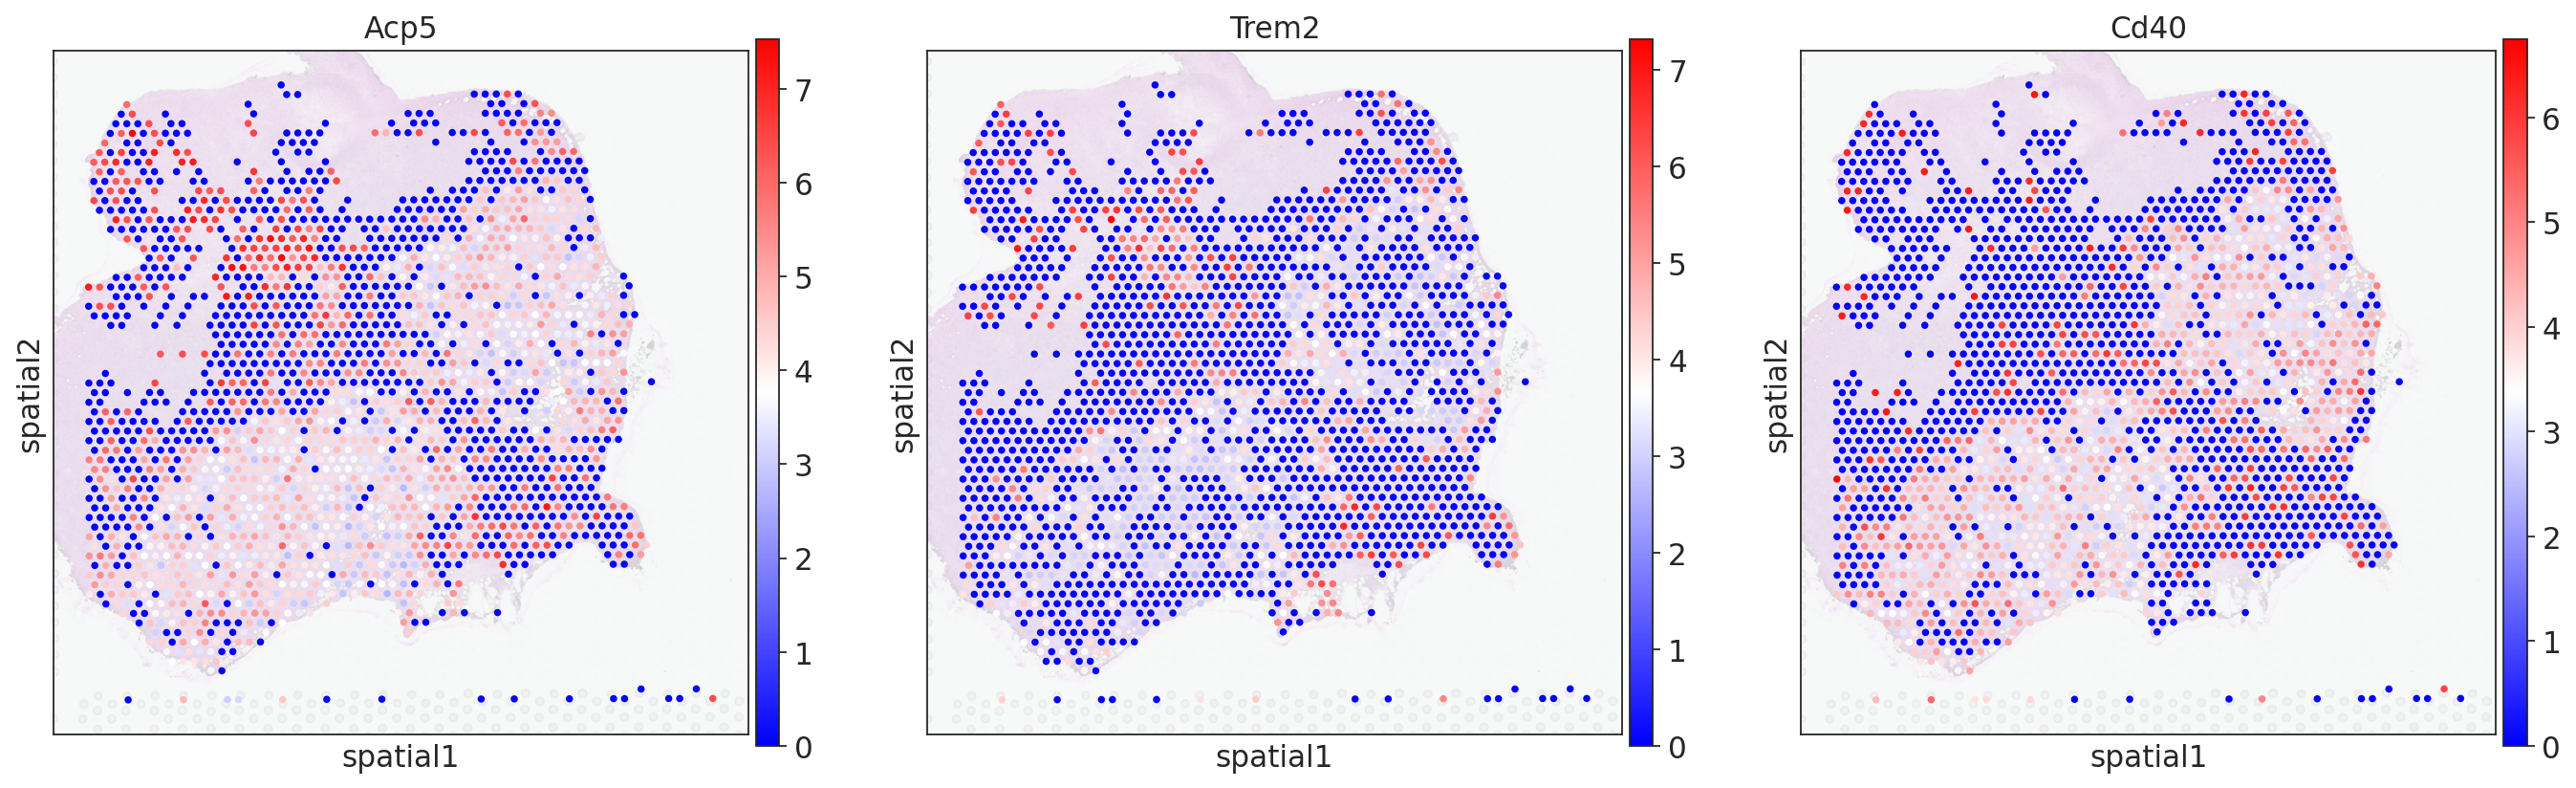

In [30]:
### Figure 4g ###

sc.pl.spatial(data.adata, 
              color=['Acp5', 'Trem2', 'Cd40'], 
            alpha_img=0.2, use_raw=False, cmap='bwr')

# Figure 5: stratifying infiltrated and peripheral MS

In [32]:
mess = data.adata.obs.loc[data.adata.obs.MixtureType.isin(['Pure Mes.','MS Mixture'])]

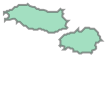

In [33]:
from shapely.geometry import Point, Polygon
from alphashape import alphashape
from descartes import PolygonPatch


#pure_m = mess.loc[mess.MixtureType == 'Pure Mes.']
pure_m = data.adata.obs.loc[data.adata.obs.region_ind == '0']
pure_m_spots = [[x,y] for x, y in zip(pure_m.array_col.tolist(), pure_m.array_row.tolist())]
pure_m_shape = alphashape(pure_m_spots, 0.45)
pure_m_shape

In [34]:
pure_m_polys = pure_m_shape.geoms

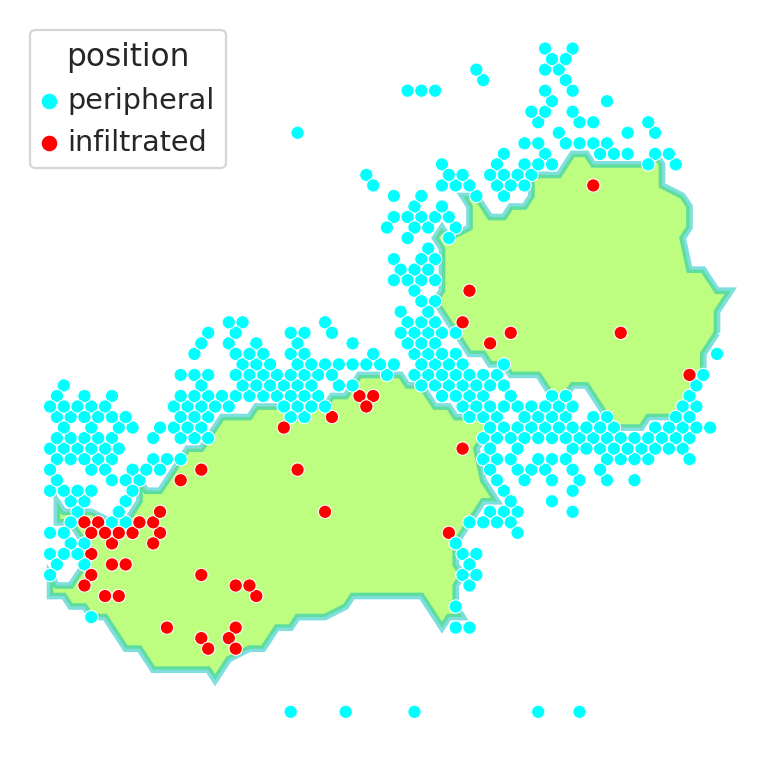

In [35]:
### Figure 5a
f, ax = plt.subplots(1,1, figsize=(6,6))
ms_mixtures = mess.loc[mess.MixtureType == 'MS Mixture']

positions = []
for x, y in zip(ms_mixtures.array_col.tolist(), ms_mixtures.array_row.tolist()):
    point = Point(x, y)
    pos = "peripheral"
    for poly in pure_m_polys:
        if poly.contains(point):
            pos = "infiltrated"
            break
        else:
            pass
    positions.append(pos)
    
ms_mixtures['position'] = positions
ax.add_patch(PolygonPatch(pure_m_shape, fc='lawngreen',
                          alpha=0.5, linewidth=3, ec='c'))
sns.scatterplot(data=ms_mixtures, x='array_col', y='array_row',
                hue='position',ax=ax, 
                palette={'infiltrated': 'red', 
                'peripheral': 'cyan'}) 
ax.axis("off")
ax.invert_yaxis()
# plt.savefig("figures/Messenchymal_Peripheral_Infiltrated_Stratify_24679.png",
#             dpi=100, bbox_inches='tight')

In [36]:
import warnings
warnings.filterwarnings("ignore")
peri_inf_res = []

peri = ms_mixtures.loc[ms_mixtures.position=='peripheral']
infi = ms_mixtures.loc[ms_mixtures.position=='infiltrated']
for ct in immune_celltypes:
    peri_c = peri[ct].to_numpy()
    infi_c = infi[ct].to_numpy()
    mdiff = np.mean(peri_c) - np.mean(infi_c)
    
    lfc = np.log2(np.mean(peri_c) / np.mean(infi_c))
    fc_pi = np.mean(peri_c) / np.mean(infi_c)
    fc_ip = np.mean(infi_c) / np.mean(peri_c)
    pval = ttest_ind(peri_c, infi_c)[1]
        
    df = pd.DataFrame(data=[[ct, mdiff, lfc, fc_pi, fc_ip,  pval]], 
                      columns=['ICT', 'Mean_PI_diff','lfc','fc_pi', 'fc_ip', 'pvalue'])
    peri_inf_res.append(df)
peri_inf_res = pd.concat(peri_inf_res)
peri_inf_res['FDR'] = padjust_test(peri_inf_res.pvalue, method='fdr_bh')[1]
peri_inf_res['FDR <= 0.05'] = np.where(peri_inf_res['FDR'] <= 0.05, 'Yes', 'No')
peri_inf_res.loc[peri_inf_res.FDR <= 0.05,:]
#peri_inf_res.to_csv("Mess_Peri_Infi_Immune_Diff_Table_24679.csv")

ICT  Mean_PI_diff       lfc     fc_pi     fc_ip  \
0                 B cells naive      0.009440  1.794821  3.469724  0.288207   
0     Dendritic cells activated      0.004255  2.349559  5.096683  0.196206   
0                Macrophages M1     -0.003974 -0.413547  0.750775  1.331957   
0            Mast cells resting      0.006945  1.563478  2.955656  0.338334   
0                   Neutrophils      0.007385  2.912311  7.528230  0.132833   
0            NK cells activated      0.007245  2.593209  6.034396  0.165717   
0                  Plasma cells      0.008859  2.637148  6.221006  0.160746   
0  T cells CD4 memory activated      0.004431  1.281948  2.431671  0.411240   
0    T cells CD4 memory resting      0.012445  1.221178  2.331369  0.428932   
0             T cells CD4 naive      0.008861  2.279849  4.856272  0.205919   
0     T cells follicular helper      0.006739  2.205965  4.613831  0.216740   
0           T cells gamma delta      0.002644  1.401742  2.642205  0.378472   

     pvalue       FDR FDR <= 0.05  
0  0.002479  0.007792         Yes  
0  0.000385  0.002116         Yes  
0  0.017618  0.035236         Yes  
0  0.003861  0.010619         Yes  
0  0.000101  0.001516         Yes  
0  0.000207  0.001516         Yes  
0  0.000556  0.002448         Yes  
0  0.015500  0.034100         Yes  
0  0.005029  0.012293         Yes  
0  0.002219  0.007792         Yes  
0  0.000190  0.001516         Yes  
0  0.021800  0.039967         Yes

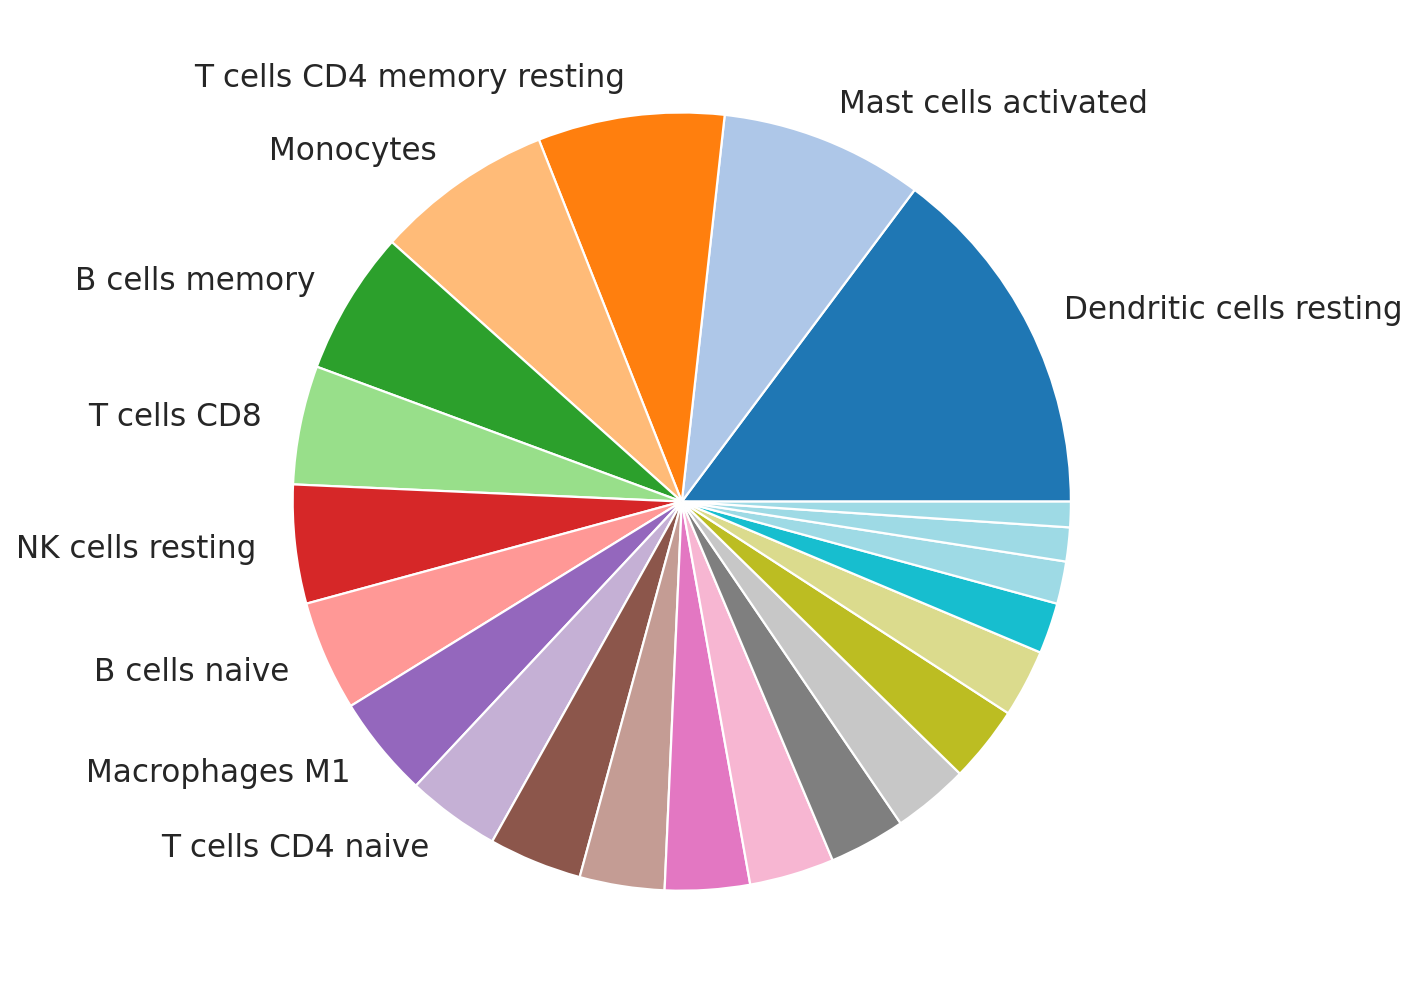

In [42]:
### Figure 5 b

ms_mixture_df = ms_mixtures[immune_celltypes + ['position']]
ms_mixture_df = pd.melt(ms_mixture_df, value_vars=immune_celltypes, id_vars=['position'],
                        var_name='celltype', value_name='proportion')
ms_mixture_df['proportion'] = (ms_mixture_df['proportion'] * 100).round(1)
peri_inf_mean_df = (ms_mixtures.groupby('position').mean().loc[:, immune_celltypes]*100).round(1)
peri_inf_mean_df = peri_inf_mean_df.reset_index()
peri_inf_mean_df = pd.melt(peri_inf_mean_df, id_vars=['position'],
                           value_vars=immune_celltypes, var_name='celltype', value_name='proportion')

peri_ct_mean = peri_inf_mean_df.loc[peri_inf_mean_df.position=='peripheral']
peri_ct_mean['pie_prop'] = (peri_ct_mean.proportion / peri_ct_mean.proportion.sum())
peri_ct_mean = peri_ct_mean.sort_values('pie_prop', ascending=False)
props = peri_ct_mean.pie_prop.to_numpy()
labels = peri_ct_mean.celltype.tolist()
print_labels = []
k = 1

cmap = plt.get_cmap("tab20")
colors = cmap(range(len(labels)))

for prop, label in zip(props, labels):
    if k <= 10:
        print_labels.append(label)
    else:
        print_labels.append('')
    k += 1
f = plt.figure(figsize=(8,8))
plt.pie(props, labels=print_labels, colors=colors);
#plt.savefig("figures/Mess_Tumor_Peripherals_Immunes_24679.png", dpi=200, bbox_inches='tight')

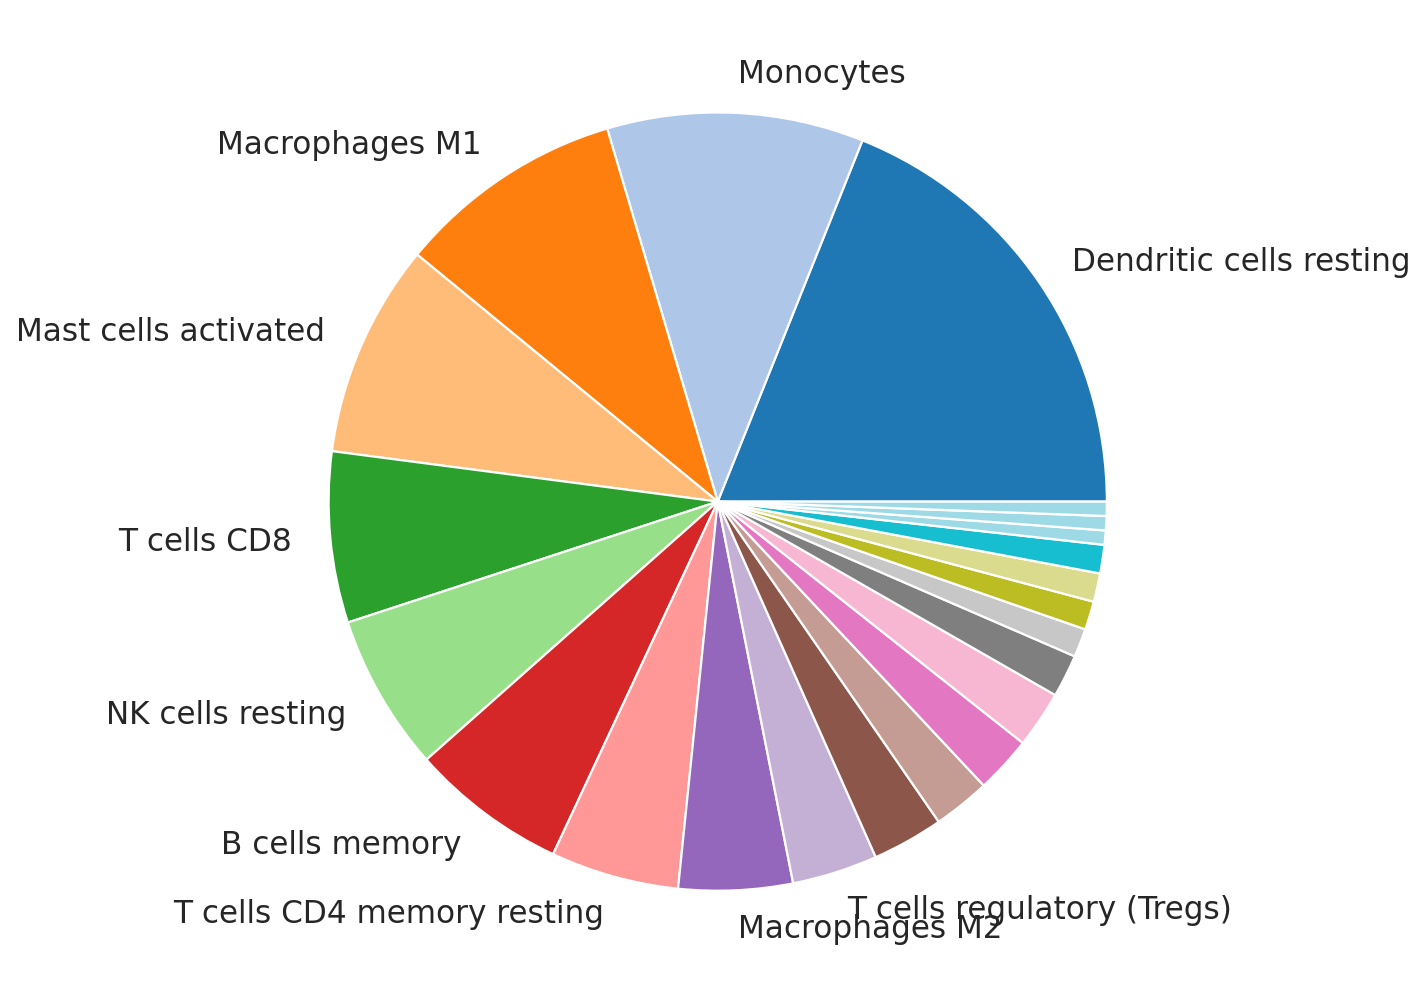

In [44]:
#### Figure 5c ####

infil_ct_mean = peri_inf_mean_df.loc[peri_inf_mean_df.position=='infiltrated']
infil_ct_mean['pie_prop'] = (infil_ct_mean.proportion / infil_ct_mean.proportion.sum())
infil_ct_mean = infil_ct_mean.sort_values('pie_prop', ascending=False)
props = infil_ct_mean.pie_prop.to_numpy()
labels = infil_ct_mean.celltype.tolist()
print_labels = []
k = 1
for prop, label in zip(props, labels):
    if k<=10:
        print_labels.append(label)
    else:
        print_labels.append('')
    k+=1
f = plt.figure(figsize=(8,8))
cmap = plt.get_cmap("tab20")
colors = cmap(range(len(labels)))
plt.pie(props, labels=print_labels,colors=colors);
#plt.savefig("figures/Mess_Tumor_Infiltrated_Immunes_24679.png", dpi=200, bbox_inches='tight')

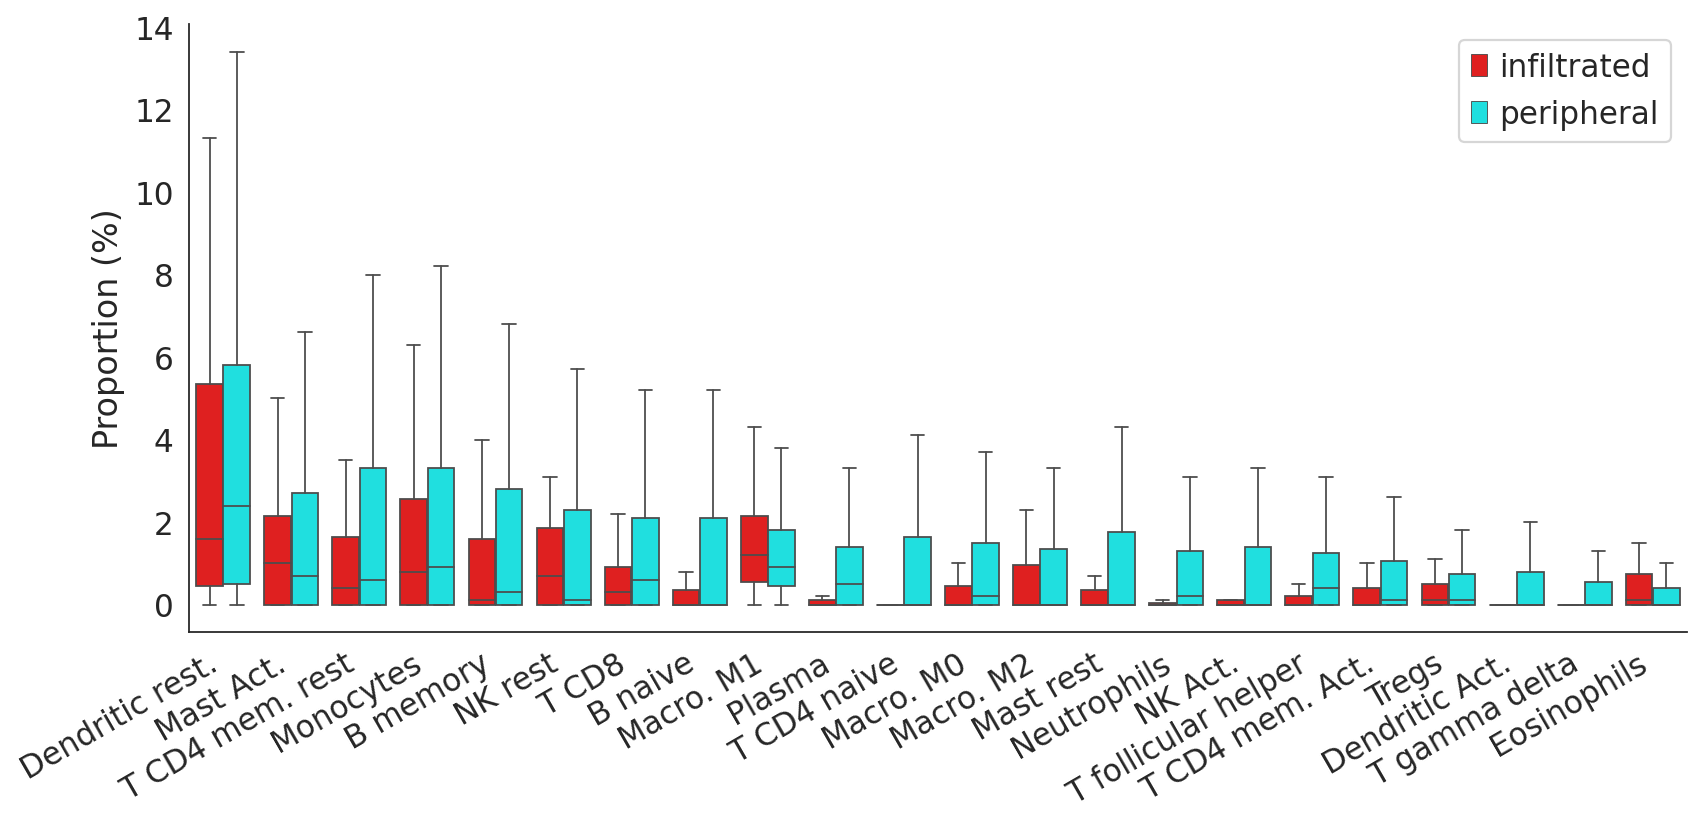

In [46]:
#### Figure 5d ####

f, ax = plt.subplots(ncols=1,nrows= 1, figsize=(12,  5))
sns.set_style('white')

cmap = {"infiltrated": "red", "peripheral": "cyan"}


x_order = peri_inf_mean_df.sort_values(["position", "proportion"], ascending=False).celltype.tolist()[:22]
sns.boxplot(data=ms_mixture_df, x='celltype',
            y='proportion', hue='position', showfliers=False, ax=ax, 
             hue_order=['infiltrated', 'peripheral'], palette=cmap,
            order=x_order, linewidth=0.8)
tick_labels = ax.get_xticklabels()
tick_labels = [immune_hmap[l.get_text()] for l in tick_labels]
ax.set_xticklabels(tick_labels, fontsize=14,rotation=30, ha='right')
sns.despine(ax=ax)
ax.set_ylabel("Proportion (%)", fontsize=15)
ax.set_xlabel("")
plt.legend(fontsize=14)
# plt.savefig("figures/Messenchymal_Peripheral_Infiltrated_Immune_Raw_Props_Box_24679_oct2022.png",
#             dpi=100, bbox_inches='tight')


Text(0.5, 1.0, 'Cd40')

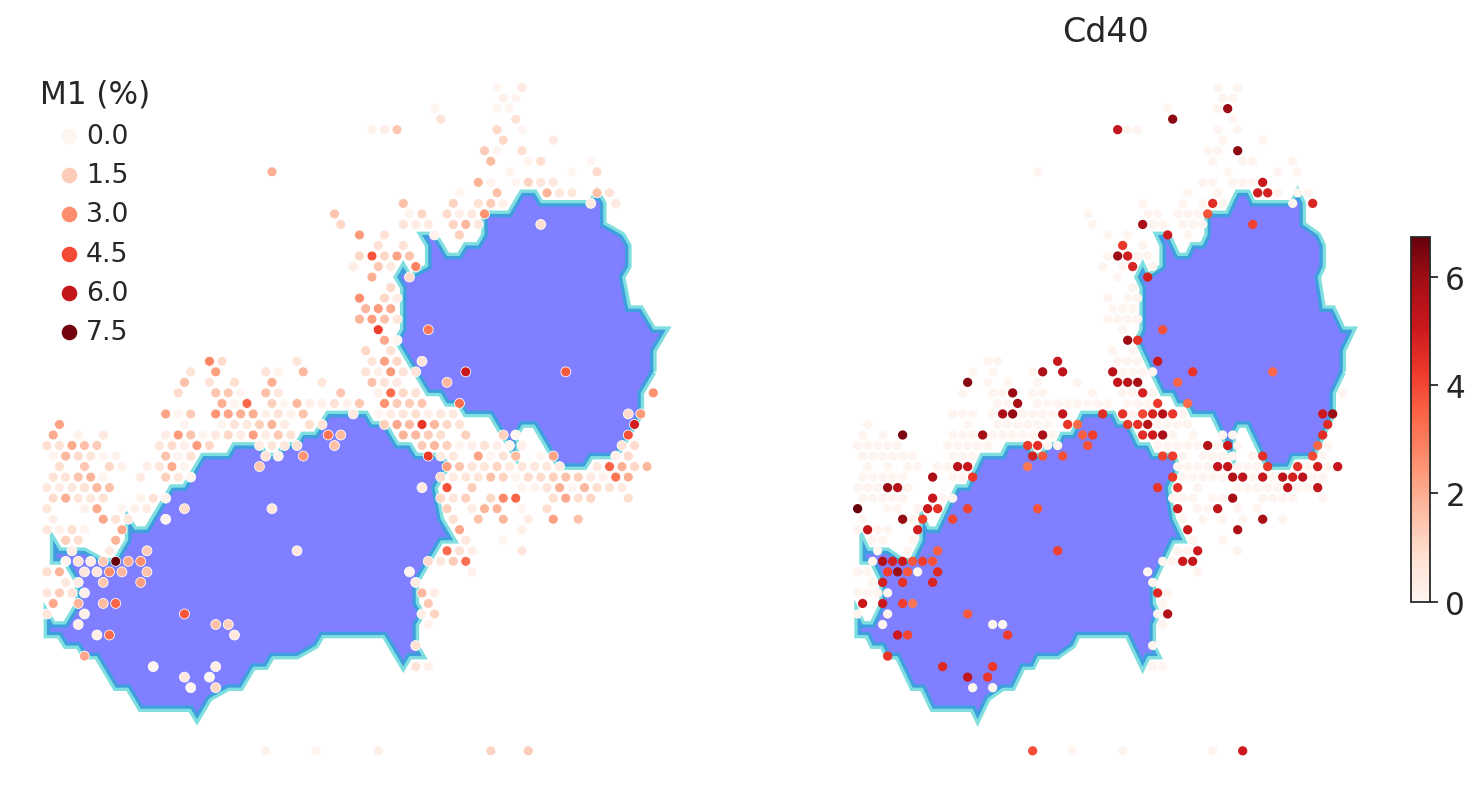

In [47]:
### Figure 5 e&f
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.add_patch(PolygonPatch(pure_m_shape, fc='blue', alpha=0.5, linewidth=3, ec='c'))
ms_mixtures_m1 = ms_mixtures.copy()
ms_mixtures_m1['Macrophages M1'] = (ms_mixtures_m1['Macrophages M1']*100).round(1)
sns.scatterplot(data=ms_mixtures_m1, x='array_col', y='array_row', hue='Macrophages M1',
                ax=ax1, palette='Reds', vmin=0.01, s=20)

ax1.legend(title='M1 (%)', frameon=False, fontsize=12)
ax1.invert_yaxis()
ax1.axis("off")

ax2.add_patch(PolygonPatch(pure_m_shape, fc='blue', alpha=0.5, linewidth=3, ec='c'))
img = ax2.scatter(x=data.adata.obs.loc[ms_mixtures_m1.index,'array_col'],
            y=data.adata.obs.loc[ms_mixtures_m1.index,'array_row'],
            c=np.ravel(data.adata[ms_mixtures_m1.index, 'Cd40'].X.toarray()),
           cmap='Reds', s=10)
plt.colorbar(img, shrink=.5, ax=ax2)
ax2.invert_yaxis()
ax2.axis("off")
ax2.set_title("Cd40", fontsize=15)

# plt.savefig("figures/Messenchymal_Peripheral_Infiltrated_M1&Cd40_patterns_24679.png",
#              dpi=100, bbox_inches='tight')